In [38]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import cv2 
from tqdm import tqdm
from video_image import get_image
import math
import os
from collections import deque
import matplotlib.gridspec as gridspec
import tqdm

# Mini-project 1: Dealing with sparse rewards in the Mountain Car environment

# 1 Introduction

### 1.1 Mountain Car Environment

In [39]:
env = gym.make('MountainCar-v0', render_mode="rgb_array")

print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")
print(f"Number of actions available: {env.action_space.n}")
print(f"Observation shape: {env.observation_space.shape}")

starting_state, _ = env.reset() 
print(f"Starting state: {starting_state}")

done = False
state, _ = env.reset()
episode_reward = 0
while not done:
    action = env.action_space.sample()
    next_state, reward, terminated, truncated, _ = env.step(action)

    episode_reward += reward

    state = next_state
    done = terminated or truncated

print(f"Episode reward after taking random actions: {episode_reward}")

Action space: Discrete(3)
Observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Number of actions available: 3
Observation shape: (2,)
Starting state: [-0.4795931  0.       ]
Episode reward after taking random actions: -200.0


### 1.2 Agents

In [41]:
class Agents():
    def __init__(self, env):
        self.done = False
        self.env = env

    def observe(self, action, next_state, reward):
        None 
    
    def select_action(self, state):
        None

    def update(self):
        None

# 2. First steps

In [42]:
class RandomAgent(Agents):
    def __init__(self, env):
        super().__init__(env)
    
    def select_action(self, state):
        return self.env.action_space.sample()

In [79]:
def episode(env, agent):
    state, _ = env.reset()
    done = False

    episode_reward = 0
    episode_length = 0
    while not done:
        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = env.step(action)

        episode_reward += reward
        episode_length += 1

        state = next_state
        done = terminated or truncated

    return episode_reward, episode_length

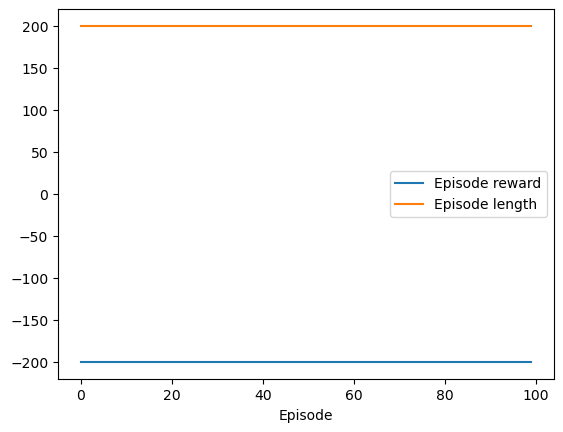

In [206]:
environment = gym.make('MountainCar-v0', render_mode="rgb_array")
agent = RandomAgent(environment)

num_episodes = 100
episode_rewards = np.empty(num_episodes)
episode_lengths = np.empty(num_episodes)
for i in range(num_episodes):
    episode_rewards[i], episode_lengths[i] = episode(environment, agent)

plt.figure()
plt.plot(episode_rewards, label="Episode reward")
plt.plot(episode_lengths, label="Episode length")
plt.xlabel("Episode") 
plt.legend()
plt.savefig("random_agent.png")

Episode rewaard and episode lentgh are always -200 and 200, which is the default value for truncated=True. 

Basically, random sample of actions never solves the problem. 

# 3. DQN

### 3.1 Implementation 

In [43]:
class Q(torch.nn.Module): 
    def __init__(self):
        super(Q, self).__init__()
        
        self.MLP = torch.nn.Sequential(
            torch.nn.Linear(2, 64),
            torch.nn.ReLU(),
            #torch.nn.Linear(64, 64),
            #torch.nn.ReLU(),
            torch.nn.Linear(64, 3))

    def forward(self, state):
        Q_values = self.MLP(state)
        return Q_values

## 3.4 Non domain-specific reward
class MLP(torch.nn.Module): 
    def __init__(self):
        super(MLP, self).__init__()
        
        self.MLP = torch.nn.Sequential(
            torch.nn.Linear(2, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1))

    def forward(self, state):
        output = self.MLP(state)
        return output

In [44]:
class ReplayBuffer:    
    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.num_samples = 0
        self.buffer = torch.zeros((self.capacity, 7))
        
    def add_observation(self, observation):
        #observation = (state, action, reward, next_state, done)
        index = self.num_samples % self.capacity

        self.buffer[index] = observation
        self.num_samples += 1

    def sample_batch(self,batch_size=64):
        record_range = min(self.num_samples, self.capacity)
        indices = torch.randint(0,record_range,size=(batch_size,))
        return self.buffer[indices]
    
    def __len__(self):
        return min(self.num_samples, self.capacity)

In [45]:
class DQNAgent(Agents):
    def __init__(self,env, epsilon = 0.9, batch_size=64):
        super().__init__(env)
        self.Q = Q()
        self.discount_factor = 0.99
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.optimizer = torch.optim.AdamW(self.Q.parameters(), lr=1e-3)
        self.replay_buffer = ReplayBuffer()

        ## 3.4 Non domain-specific reward
        self.target_network = MLP()
        self.target_network.requires_grad_(False)
        self.predictor_network = MLP()
        self.predictor_optimizer = torch.optim.AdamW(self.predictor_network.parameters(), lr=1e-3)

    def observe(self, state, action, reward, next_state, done):
        self.replay_buffer.add_observation(torch.tensor([state[0], state[1], action, reward, next_state[0], next_state[1], done], dtype=torch.float32))

    def update_epsilon(self):
        self.epsilon *= 0.99
        self.epsilon = max(self.epsilon, 0.05)
    
    def select_action(self, state):
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        else:
            with torch.no_grad():
                q = self.Q(torch.tensor(state, dtype=torch.float32)).numpy()
                max_indices = np.argwhere(q == q.max())
                return np.random.choice(max_indices[0])
    
    def update(self):
        #batch.shape = (B, (S_x, S_v, A, R, S'_x, S'_v))
        batch = self.replay_buffer.sample_batch(self.batch_size)
        self.optimizer.zero_grad()

        batch_next_state_Q_values = self.Q(batch[:, 4:6]).clone().detach() # shape = (B, 3) 3 is action space
        
        current_Q_value =  torch.gather(self.Q(batch[:, :2]), dim=1, index=batch[:, 2].long().unsqueeze(1)).squeeze(1)
        batch_next_state_max_Q_value = torch.max(batch_next_state_Q_values, dim=1).values
        target_Q_value = batch[:, 3] + self.discount_factor*batch_next_state_max_Q_value*(1-batch[:, 6]) # Only reward if state is done
        loss = torch.functional.F.mse_loss(current_Q_value, target_Q_value)
        
        #batch_max_next_state_Q_value = torch.max(batch_next_state_Q_values, dim=1).values
        #loss = 0.5 * torch.mean((batch[:, 3] + self.discount_factor*batch_max_next_state_Q_value 
        #              - self.Q(batch[:, :2])[:, batch[:, 2].int()])**2)
        
        loss.backward()
        self.optimizer.step()

        ## 3.4 Non domain-specific reward
        next_states = batch[:, 4:6]
        targets = self.target_network(next_states)
        predictions = self.predictor_network(next_states)
        loss_predictor = torch.functional.F.mse_loss(predictions, targets)
        loss_predictor.backward()
        self.predictor_optimizer.step()

        return loss.item()    
    
    ## 3.4 Non domain-specific reward
    def RND_reward(self, next_states):
        next_states = torch.tensor(next_states, dtype=torch.float32)
        next_states = (next_states - torch.mean(next_states, dim=0))/torch.std(next_states, dim=0)
        rnd_reward = torch.functional.F.mse_loss(self.target_network(next_states), self.predictor_network(next_states)).detach().numpy()
        #rnd_reward = (rnd_reward - torch.mean(rnd_reward))/np.std(rnd_reward) TO DO: running estimate of its mean
        rnd_reward = -5 if rnd_reward < -5 else rnd_reward
        rnd_reward = 5 if rnd_reward > 5 else rnd_reward
        return rnd_reward
    
    ## 4.5 compare DQN and dyna 
    def set_zero_epsilon(self):
        self.epsilon = 0

### 3.2 No auxiliary reward

In [46]:
def run_episode_DQN(agent, render=False, video_path="video.mp4", truncation = 200):

    state, _ = environment.reset()
    done = False
    
    episode_reward = 0
    episode_length = 0
    if render:
        frame = environment.render()
        height, width, _ = frame.shape

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(video_path, fourcc, 20.0, (width, height))

    while not done:
        if render:
            frame = environment.render()
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            out.write(frame)

        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = environment.step(action)
        agent.observe(state, action, reward, next_state, terminated)

        #if terminated:
            #print("Goal Found:", episode_reward, episode_length)

        if (len(agent.replay_buffer) > agent.batch_size):
            agent.update()
            agent.update_epsilon()
        
        episode_reward += reward
        episode_length += 1
        state = next_state
        done = terminated or (episode_reward - 1 < -truncation)
        
    if render:
        out.release()
    return episode_reward, episode_length

In [211]:
environment = gym.make('MountainCar-v0', render_mode="rgb_array")
agent = DQNAgent(environment)

list_rewards, list_lengths = ([], [])
for episode in tqdm(range(1000)):
    if (episode==999): kwargs = dict(render=True, video_path="video_dqn_3.2_trunc200.mp4")
    else: kwargs = dict(render=False)

    episode_reward, episode_length = run_episode_DQN(agent=agent, **kwargs)
    list_rewards.append(episode_reward)
    list_lengths.append(episode_length)

100%|██████████| 1000/1000 [02:46<00:00,  5.99it/s]


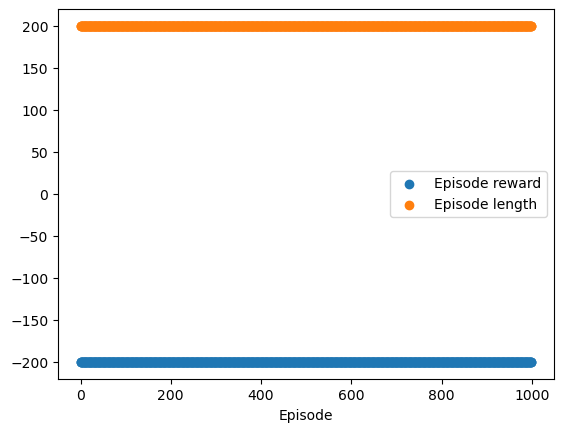

In [212]:
plt.figure()
plt.scatter(np.arange(len(list_rewards)),list_rewards, label="Episode reward")
plt.scatter(np.arange(len(list_lengths)),list_lengths, label="Episode length")
plt.xlabel("Episode") 
plt.legend()
plt.savefig("dqn_3.2_200.png")

In [213]:
environment = gym.make('MountainCar-v0', render_mode="rgb_array")
agent = DQNAgent(environment)

list_rewards, list_lengths = ([], [])
for episode in tqdm(range(1000)):
    if (episode==999): kwargs = dict(render=True, video_path="video_dqn_3.2_trunc1000.mp4")
    else: kwargs = dict(render=False)

    total_reward, duration = run_episode_DQN(agent=agent, truncation=1000, **kwargs)
    list_rewards.append(total_reward)
    list_lengths.append(duration)

100%|██████████| 1000/1000 [03:52<00:00,  4.30it/s]


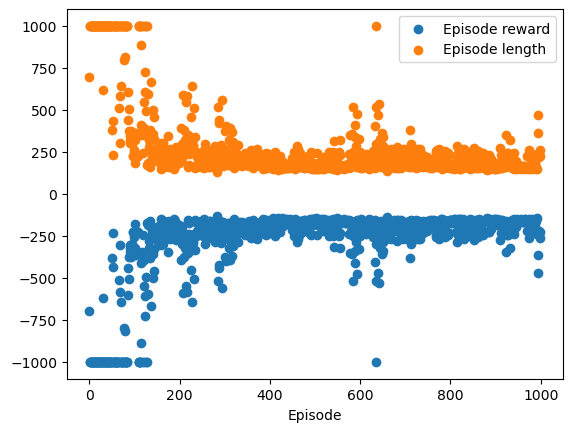

In [214]:
plt.figure()
plt.scatter(np.arange(len(list_rewards)),list_rewards, label="Episode reward")
plt.scatter(np.arange(len(list_lengths)),list_lengths, label="Episode length")
plt.xlabel("Episode") 
plt.legend()
plt.savefig("dqn_3.2_1000.png")

Because of the sparse reward, the agend doesn't solve the task for episodes shorter than approximately 250 steps, tipycally not for the default duration 200 steps. If we allow longer steps, the agent is equivalent to random until it reaches once the goal, and after that it improves (his episode lenghts/episode rewards lowers/augments).

### 3.3 Heuristic reward function

In [47]:
def heuristic_reward_function(next_state):
    position, velocity = next_state

    # favour high speed to be able to climb the hill
    velocity_reward = np.abs(velocity)/0.07

    # favour positions close to the goal state 
    goal_position = 0.5
    position_reward = -(goal_position-position)/1.8

    # scale each reward 
    heuristic_reward = -0.5 * position_reward + 0.5 * velocity_reward

    return heuristic_reward

In [48]:
def run_episode_heuristic_DQN(agent, render=False, video_path="video.mp4", truncation = 200, reward_factor=1, return_loss=False):

    state, _ = environment.reset()
    done = False
    
    episode_total_reward = 0
    episode_length = 0
    episode_environment_reward = 0
    episode_auxiliary_reward = 0
    num_success = 0
    loss_episode = []
    if render:
        frame = environment.render()
        height, width, _ = frame.shape

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(video_path, fourcc, 20.0, (width, height))

    while not done:
        if render:
            frame = environment.render()
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            out.write(frame)

        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = environment.step(action) 
        total_reward = reward + reward_factor * heuristic_reward_function(next_state) 

        agent.observe(state, action, total_reward, next_state, terminated)

        #if terminated:
            #print("Goal Found:", episode_reward, episode_length)

        if (len(agent.replay_buffer) > agent.batch_size):
            loss = agent.update()
            loss_episode.append(loss)
            agent.update_epsilon()
        
        episode_total_reward += total_reward
        episode_environment_reward += reward
        episode_auxiliary_reward += reward_factor * heuristic_reward_function(next_state)
        episode_length += 1
        state = next_state
        done = terminated or episode_length > truncation
        if terminated: num_success += 1
        
    if render:
        out.release()
    
    return episode_total_reward, episode_length, episode_environment_reward, episode_auxiliary_reward, num_success, loss_episode

In [44]:
environment = gym.make('MountainCar-v0', render_mode="rgb_array")
agent = DQNAgent(environment)

list_rewards, list_lengths = ([], [])
list_environment_reward, list_auxiliary_reward = ([], [])
list_num_success = []
list_loss_episode = []
for episode in tqdm(range(3000)):
    if (episode==2999): kwargs = dict(render=True, video_path="video_dqn_3.3_trunc200.mp4")
    else: kwargs = dict(render=False)

    total_reward, duration, environment_reward, auxiliary_reward, num_success, loss_episode = run_episode_heuristic_DQN(agent=agent,truncation = 200, **kwargs)
    list_rewards.append(total_reward)
    list_lengths.append(duration)
    list_environment_reward.append(environment_reward)
    list_auxiliary_reward.append(auxiliary_reward)
    list_num_success.append(num_success)
    list_loss_episode.append(np.mean(loss_episode))

100%|██████████| 3000/3000 [07:57<00:00,  6.28it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


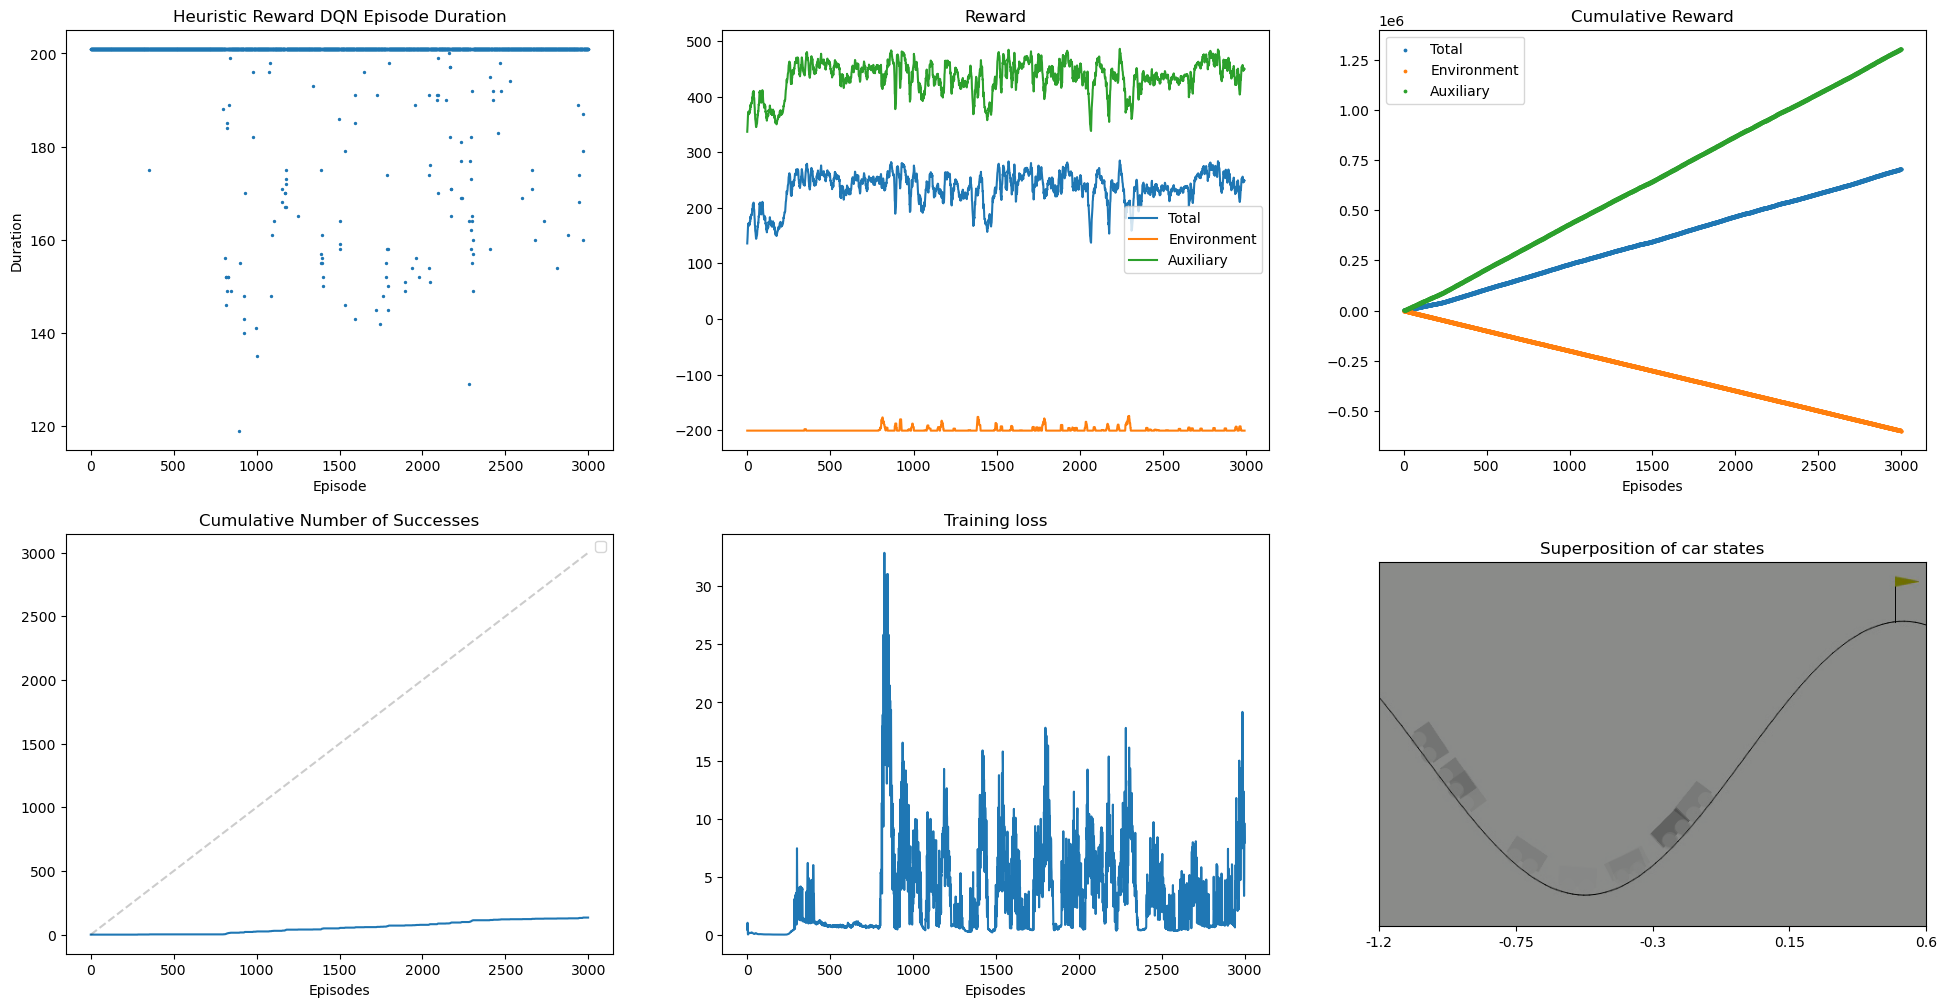

In [45]:
window = 10
def moving_average(arr, window_size):
    return np.convolve(arr, np.ones(window_size), 'valid') / window_size

fig, ax = plt.subplots(2, 3, figsize = (24, 12))

smooth = moving_average(list_rewards, window)
ax[0,1].plot(np.arange(len(smooth)), smooth, label="Total")#à, s=3)
smooth = moving_average(list_environment_reward, window)
ax[0,1].plot(np.arange(len(smooth)), smooth, label="Environment")#à, s=3)
smooth = moving_average(list_auxiliary_reward, window)
ax[0,1].plot(np.arange(len(smooth)), smooth, label="Auxiliary")#à, s=3)
ax[0,1].legend(loc ='center right')
ax[0,1].set_title('Reward')

ax[0,2].scatter(np.arange(3000), np.cumsum(list_rewards), s=3, label="Total")
ax[0,2].scatter(np.arange(3000), np.cumsum(list_environment_reward), s=3, label = "Environment")
ax[0,2].scatter(np.arange(3000), np.cumsum(list_auxiliary_reward), s=3, label="Auxiliary")
#ax[1].plot(np.arange(3000), np.cumsum(list_num_success))#, s=3)
ax[0,2].legend()
#ax[2].plot(np.arange(3000), np.arange(3000), ls='--', color=(0, 0, 0, 0.2))#, s=3)
#ax[2].set_title('Cumulative Number of Successes') #(np.arange(3000), np.arange(3000), ls='--', color=(0, 0, 0, 0.2))#, s=3)
ax[0,2].set_title('Cumulative Reward')
ax[0,0].set_xlabel('Episodes')
#ax[2].set_xlabel('Episodes')
ax[0,2].set_xlabel('Episodes')

#ax[1,1].plot(np.arange(len(moving_average(list_loss_episode, 10))),moving_average(list_loss_episode, 10))
ax[1,1].plot(np.arange(len(list_loss_episode)),list_loss_episode)
ax[1,1].set_title('Training loss')
ax[1,1].set_xlabel('Episodes')

#smooth =  moving_average(list_lengths, window_size=100)
#ax[1,0].scatter(np.arange(len(smooth)), smooth, s=2)
ax[0,0].scatter(np.arange(len(list_lengths)), list_lengths, s=2)
ax[0,0].set_title('Heuristic Reward DQN Episode Duration')
ax[0,0].set_ylabel('Duration')
ax[0,0].set_xlabel('Episode')

ax[1,0].plot(np.arange(3000), np.cumsum(list_num_success))#, s=3)
ax[1,0].legend()
ax[1,0].plot(np.arange(3000), np.arange(3000), ls='--', color=(0, 0, 0, 0.2))#, s=3)
ax[1,0].set_title('Cumulative Number of Successes') #(np.arange(3000), np.arange(3000), ls='--', color=(0, 0, 0, 0.2))#, s=3)
ax[1,0].set_xlabel('Episodes')
ax[1,1].set_xlabel('Episodes')

ax[1,2].imshow(get_image('video_dqn_3.3_trunc200.mp4'))
ax[1,2].set_title('Superposition of car states')
ax[1,2].set_xlabel(' ')
ax[1,2].set_ylabel(' ')
ax[1,2].set_yticks([])
ax[1,2].set_xticks(np.linspace(0, 600, 5),[round(x, 2) for x in  list(np.linspace(-1.2, 0.6, 5))])
plt.savefig('3.2_factor5.png', bbox_inches="tight", dpi=300)
plt.show()

## 3.4 RND

In [20]:
environment = gym.make('MountainCar-v0', render_mode="rgb_array")

In [63]:
class ReplayBuffer:    
    def __init__(self, capacity=int(1e4)):
        self.capacity = capacity
        self.num_samples = 0
        self.buffer = torch.zeros((self.capacity, 7))
        
    def add_observation(self, observation):
        #observation = (state_position, state_speed, action, reward, next_state_position, next_state_speed, done)
        index = self.num_samples % self.capacity

        self.buffer[index] = observation
        self.num_samples += 1

    def sample_batch(self,batch_size=64):
        record_range = min(self.num_samples, self.capacity)
        indices = torch.randint(0, record_range, (batch_size,))
        return self.buffer[indices]

    def __len__(self):
        return min(self.num_samples, self.capacity)

In [93]:
class Q(torch.nn.Module):
    def __init__(self):
        super(Q, self).__init__()
        self.MLP = torch.nn.Sequential(
            torch.nn.Linear(2, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 3),
        )

    def forward(self,state):
        Q_values = self.MLP(state)
        return Q_values

class mlp(torch.nn.Module):
    def __init__(self):
        super(mlp, self).__init__()
        self.MLP = torch.nn.Sequential(
            torch.nn.Linear(2, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1),
        )
    def forward(self,x):
        y = self.MLP(x)
        return y

class DQN_Agent_RND():
    def __init__(self, epsilon = 0.95, batch_size=64, norm_beta = 0.5):
        self.Q = Q()

        self.predictor = mlp()
        self.target = mlp()
        self.discount_factor = 0.99
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.optimizer = torch.optim.AdamW(self.Q.parameters(), lr=1e-3)
        self.rnd_optimizer = torch.optim.AdamW(self.predictor.parameters(), lr=1e-3)

        self.running_state_mean = torch.zeros(2)
        self.running_state_ssd = torch.ones(2)
        self.running_reward_mean = 0
        self.running_reward_ssd = 1
        self.replay_buffer = ReplayBuffer()
        self.steps = 0
        
    def observe(self, state, action, reward, next_state, done):
        self.replay_buffer.add_observation(
            torch.tensor([state[0], state[1], action, reward, next_state[0], next_state[1], done], dtype=torch.float32)
            )
    
    def update_epsilon(self):
        self.epsilon *= 0.995
        self.epsilon = max(self.epsilon, 0.05)

    def select_action(self, state):
        if random.random() > self.epsilon:
            with torch.no_grad():
                q_values = self.Q(torch.tensor(state, dtype=torch.float32)).numpy()
                max_q_value = np.max(q_values)
                max_actions = np.where(q_values == max_q_value)[0]
                
                return np.random.choice(max_actions)
        else:
            return environment.action_space.sample()
    
    def normalize_state(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        
        old_mean = self.running_state_mean.clone()
        self.running_state_ssd += (state - old_mean) * (state - self.running_state_mean)

        if self.steps > 1:
            variance = self.running_state_ssd / (self.steps - 1)
        else:
            variance = torch.ones_like(self.running_state_mean)  # Avoid division by zero
        std_dev = torch.sqrt(variance)
        running_state_std = std_dev
        self.running_state_mean += (state - self.running_state_mean) / self.steps
        
        state_norm = (state - old_mean) / running_state_std
        return state_norm
    
    def normalize_rnd_reward(self, rnd_reward):
        old_mean = np.copy(self.running_reward_mean)
        self.running_reward_mean += (rnd_reward - self.running_reward_mean) / self.steps
        self.running_reward_ssd += (rnd_reward - old_mean) * (rnd_reward - self.running_reward_mean)

        if self.steps > 1:
            variance = self.running_reward_ssd / (self.steps - 1)
        else:
            variance = 1
        std_dev = np.sqrt(variance)
        running_reward_std = std_dev
        
        rnd_norm = (rnd_reward - old_mean) / running_reward_std
        return rnd_norm
    
    def update(self):
        #batch = (B, (state_position, state_speed, action, reward, next_state_position, next_state_speed, done))
        batch = self.replay_buffer.sample_batch(self.batch_size)
        self.optimizer.zero_grad()


        current_Q_value =  torch.gather(self.Q(batch[:, :2]), dim=1, index=batch[:, 2].long().unsqueeze(1)).squeeze(1)
        batch_next_state_Q_values = self.Q(batch[:, 4:6]).clone().detach() # shape = (B, 3) 3 is action space
        batch_next_state_max_Q_value = torch.max(batch_next_state_Q_values, dim=1).values
        target_Q_value = batch[:, 3] + self.discount_factor*batch_next_state_max_Q_value*(1-batch[:, 6]) # Only reward if state is done

        loss = torch.functional.F.mse_loss(current_Q_value, target_Q_value)
        
        loss.backward()
        self.optimizer.step()

        target_output = self.target(batch[:, 4:6]).detach()
        predictor_output = self.predictor(batch[:, 4:6])
        rnd_reward = torch.functional.F.mse_loss(predictor_output, target_output)
        rnd_reward.backward()
        self.rnd_optimizer.step()
        return loss.item(), rnd_reward.item()
    
    def compute_rnd_reward(self, next_state):
        rnd_reward = 0
        self.steps+=1
        if self.steps > 10:
            with torch.no_grad():
                next_state = self.normalize_state(next_state)
                
                next_state = torch.tensor(next_state, dtype=torch.float32)
                pred = self.predictor(next_state)
                target = self.target(next_state)

                rnd_reward = ((pred - target) ** 2).item()
                rnd_reward = self.normalize_rnd_reward(rnd_reward)
                rnd_reward = np.clip(rnd_reward, -5, 5)
        #else: 
            #self.normalize_state(next_state)
        return rnd_reward


def run_episode_RND(agent, render=False, video_path="video.mp4", truncated_cap=200, reward_factor = 0.2, seed=None):
    state, _ = environment.reset()
    if seed is not None: 
        state, _ = environment.reset(seed=seed)
    done = False
    
    episode_reward = 0
    episode_environment_reward = 0
    episode_rnd_reward = 0
    duration = 0
    success = 0
    episode_loss = []
    if render:
        frame = environment.render()
        height, width, _ = frame.shape

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(video_path, fourcc, 20.0, (width, height))

    while not done:
        if render:
            frame = environment.render()
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            out.write(frame)

        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = environment.step(action)
        episode_environment_reward += reward
        rnd_reward = agent.compute_rnd_reward(next_state)*reward_factor
        episode_rnd_reward += rnd_reward
        reward = reward + rnd_reward
        agent.observe(state, action, reward, next_state, terminated)

        if (len(agent.replay_buffer) > agent.batch_size):
            q_network_loss = agent.update()
            episode_loss.append(q_network_loss)
            agent.update_epsilon()
        
        episode_reward += reward
        duration += 1
        if (terminated): success+=1
        state = next_state
        done = terminated or (duration > truncated_cap-1)

    if render:
        out.release()
    return episode_reward, episode_environment_reward, episode_rnd_reward, duration, success, episode_loss

#run_episode_DQN()

In [32]:
DQN_agent = DQN_Agent_RND()

In [33]:
#agent = DQN_Agent_RND()
list_total_rewards, list_env_rewards, list_heur_rewards, list_durations, list_success, list_loss = ([], [], [], [], [], [])

for episode in tqdm.tqdm(range(3000)):
    if (episode==2999 or episode==50 or episode==200): kwargs = dict(render=True, video_path=f"video_dqn_rnd_{episode}.mp4")
    else: kwargs = dict(render=False)

    total_reward, env_reward, heur_reward, duration, success, episode_loss = run_episode_RND(agent=agent , **kwargs, truncated_cap=200)
    agent.update_epsilon()
    list_total_rewards.append(total_reward)
    list_env_rewards.append(env_reward)
    list_heur_rewards.append(heur_reward)
    list_success.append(success)
    list_loss.append(np.mean(episode_loss))
    list_durations.append(duration)

  0%|          | 0/3000 [00:00<?, ?it/s]/var/folders/m2/wlyv38w50tz66_hy85p5msy40000gn/T/ipykernel_34206/1716440609.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(next_state, dtype=torch.float32)
100%|██████████| 3000/3000 [05:43<00:00,  8.73it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


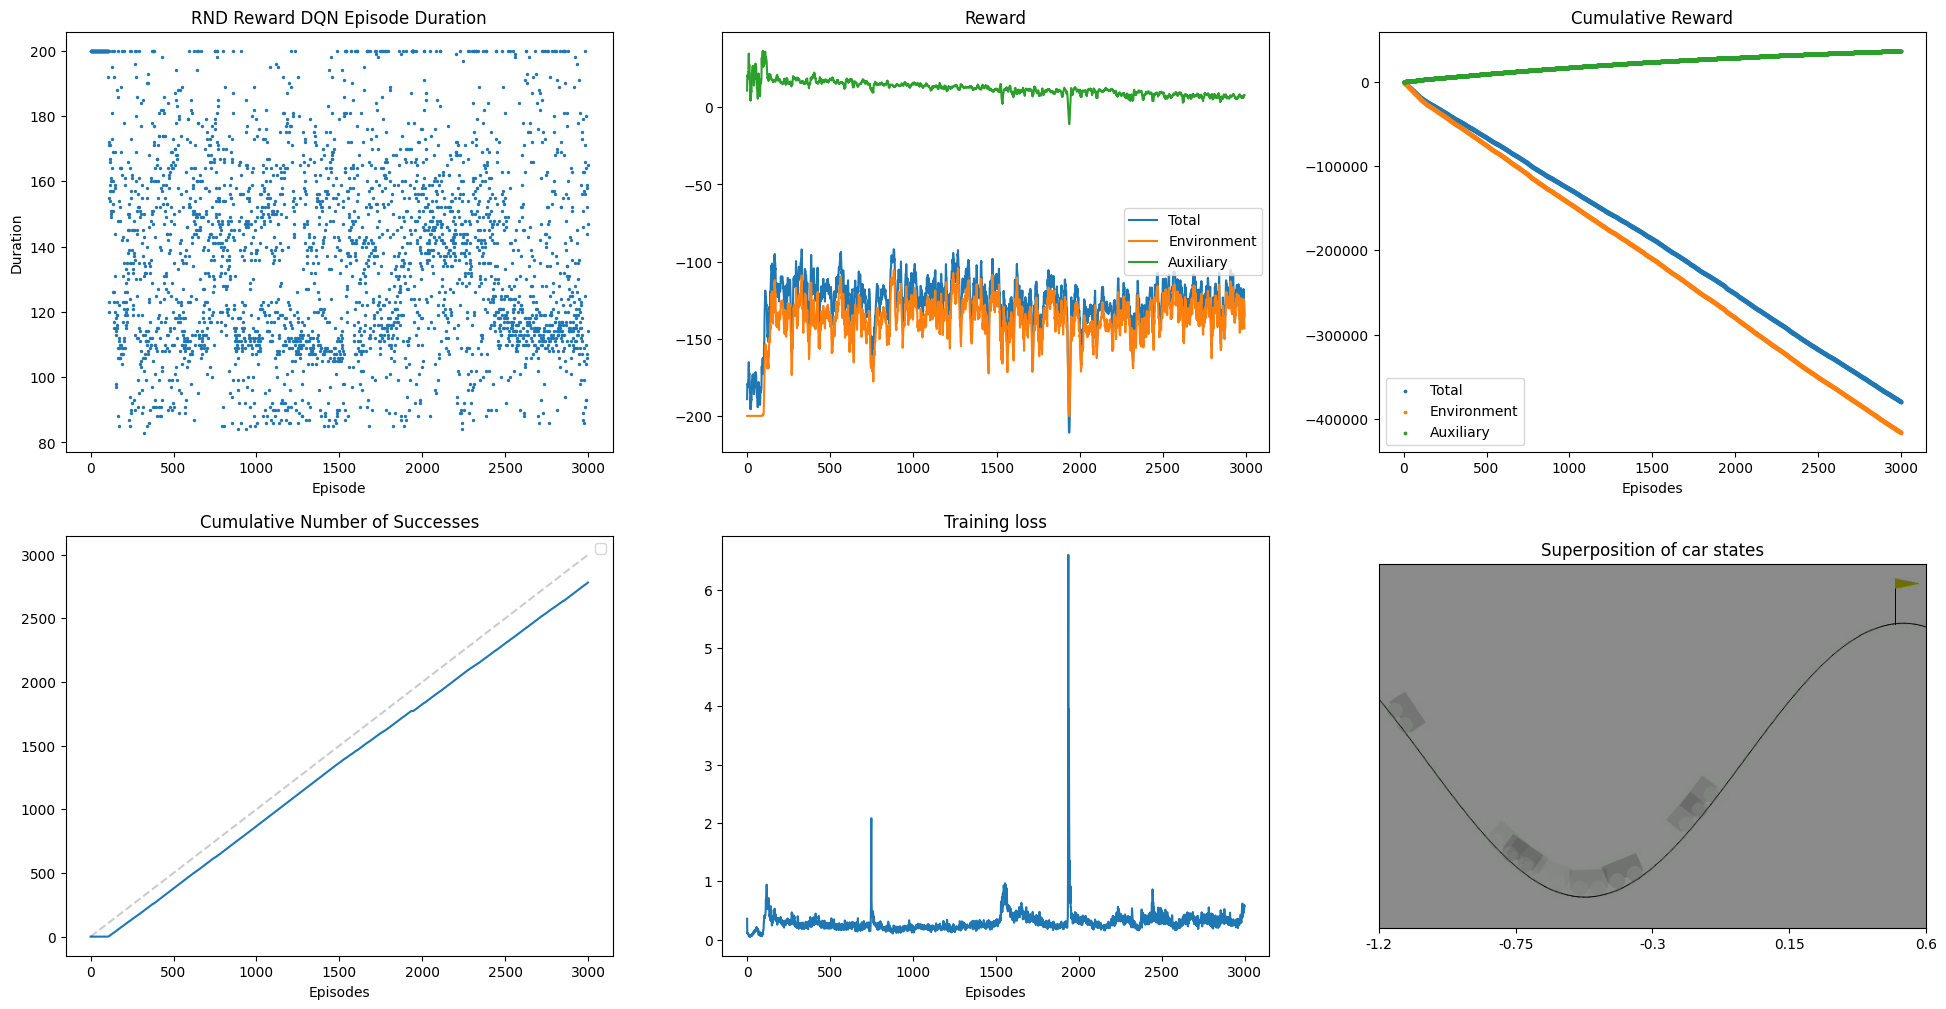

In [36]:
window = 10
def moving_average(arr, window_size):
    return np.convolve(arr, np.ones(window_size), 'valid') / window_size

fig, ax = plt.subplots(2, 3, figsize = (24, 12))

smooth = moving_average(list_total_rewards, window)
ax[0,1].plot(np.arange(len(smooth)), smooth, label="Total")#à, s=3)
smooth = moving_average(list_env_rewards, window)
ax[0,1].plot(np.arange(len(smooth)), smooth, label="Environment")#à, s=3)
smooth = moving_average(list_heur_rewards, window)
ax[0,1].plot(np.arange(len(smooth)), smooth, label="Auxiliary")#à, s=3)
ax[0,1].legend(loc ='center right')
ax[0,1].set_title('Reward')

ax[0,2].scatter(np.arange(3000), np.cumsum(list_total_rewards), s=3, label="Total")
ax[0,2].scatter(np.arange(3000), np.cumsum(list_env_rewards), s=3, label = "Environment")
ax[0,2].scatter(np.arange(3000), np.cumsum(list_heur_rewards), s=3, label="Auxiliary")
#ax[1].plot(np.arange(3000), np.cumsum(list_num_success))#, s=3)
ax[0,2].legend()
#ax[2].plot(np.arange(3000), np.arange(3000), ls='--', color=(0, 0, 0, 0.2))#, s=3)
#ax[2].set_title('Cumulative Number of Successes') #(np.arange(3000), np.arange(3000), ls='--', color=(0, 0, 0, 0.2))#, s=3)
ax[0,2].set_title('Cumulative Reward')
ax[0,0].set_xlabel('Episodes')
#ax[2].set_xlabel('Episodes')
ax[0,2].set_xlabel('Episodes')

#ax[1,1].plot(np.arange(len(moving_average(list_loss_episode, 10))),moving_average(list_loss_episode, 10))
ax[1,1].plot(np.arange(len(list_loss)),list_loss)
ax[1,1].set_title('Training loss')
ax[1,1].set_xlabel('Episodes')

#smooth =  moving_average(list_lengths, window_size=100)
#ax[1,0].scatter(np.arange(len(smooth)), smooth, s=2)
ax[0,0].scatter(np.arange(len(list_durations)), list_durations, s=2)
ax[0,0].set_title('RND Reward DQN Episode Duration')
ax[0,0].set_ylabel('Duration')
ax[0,0].set_xlabel('Episode')

ax[1,0].plot(np.arange(3000), np.cumsum(list_success))#, s=3)
ax[1,0].legend()
ax[1,0].plot(np.arange(3000), np.arange(3000), ls='--', color=(0, 0, 0, 0.2))#, s=3)
ax[1,0].set_title('Cumulative Number of Successes') #(np.arange(3000), np.arange(3000), ls='--', color=(0, 0, 0, 0.2))#, s=3)
ax[1,0].set_xlabel('Episodes')
ax[1,1].set_xlabel('Episodes')

ax[1,2].imshow(get_image('video_dqn_rnd_2999.mp4'))
ax[1,2].set_title('Superposition of car states')
ax[1,2].set_xlabel(' ')
ax[1,2].set_ylabel(' ')
ax[1,2].set_yticks([])
ax[1,2].set_xticks(np.linspace(0, 600, 5),[round(x, 2) for x in  list(np.linspace(-1.2, 0.6, 5))])
plt.savefig('3.4_RND_REAL.png', bbox_inches="tight", dpi=300)
plt.show()

# 4. Dyna

In [101]:
class DynaAgent():
    def __init__(self, env, discr_step=(0.025, 0.005), eps=0.9, k=10, path='./dyna_data/'):
        self.env = env
        self.path = path
        self.discr_step = discr_step
        self.state_space = self.env.observation_space
        self.action_space = self.env.action_space
        self.dstate_bins = [np.arange(self.state_space.low[0], self.state_space.high[0], discr_step[0]),
                            np.arange(self.state_space.low[1], self.state_space.high[1], discr_step[1])]
        
        self.n_states = len(self.dstate_bins[0]) * len(self.dstate_bins[1])
        self.n_actions = self.action_space.n
        
        self.gamma = 0.99
        self.k = k
        self.eps = eps
        self.eps_min = 0.05
        self.eps_decay_rate = 1 / 10000
        
        self.Q = np.zeros((self.n_states, self.n_actions))
        
        # Initialize model
        self.transitions = np.zeros((self.n_states, self.n_actions, self.n_states))
        self.rewards = np.zeros((self.n_states, self.n_actions))
        
        self.n_steps = 0
        self.replay_buffer = deque(maxlen=10000)

    def discretize_state(self, state):
        dstate_idx = [np.digitize(state[i], self.dstate_bins[i]) - 1 for i in range(len(state))]
        return dstate_idx[0] * len(self.dstate_bins[1]) + dstate_idx[1]

    def get_eps_threshold(self):
        return self.eps_min + (self.eps - self.eps_min) * math.exp(-1. * self.n_steps * self.eps_decay_rate)

    def select_action(self, state):
        state = self.discretize_state(state)
        
        eps_sample = random.random()
        eps_threshold = self.get_eps_threshold()
        self.n_steps += 1
        
        if eps_sample > eps_threshold:
            action = np.argmax(self.Q[state])
        else: 
            action = self.action_space.sample()
            
        return action

    def observe(self, state, action, next_state, reward, done):
        state = self.discretize_state(state)
        next_state = self.discretize_state(next_state)
        self.replay_buffer.append((state, action, next_state, reward))
        
        # Update model of transitions and rewards for taking action in state
        self.transitions[state][action][next_state] += 1
        self.rewards[state][action] = reward

    def update_qvalue(self, state, action, next_state, reward):
        transition = self.transitions[state][action] / np.sum(self.transitions[state][action])  # normalized transitions prob
        self.Q[state, action] = self.rewards[state][action] + self.gamma * np.sum(transition * np.max(self.Q, axis=-1))
        return self.Q[state, action]

    def update(self):
        if len(self.replay_buffer) > 0:
            state, action, next_state, reward = self.replay_buffer[-1]
            prev_Q = self.Q[state, action]
            new_Q = self.update_qvalue(state, action, next_state, reward)
            return new_Q - prev_Q

    def planning(self):
        for _ in range(self.k):
            state, action, next_state, reward = random.choice(self.replay_buffer)
            self.update_qvalue(state, action, next_state, reward)

    def save(self):
        if not os.path.exists(self.path):
            os.makedirs(self.path)
        np.save(self.path + 'P.npy', self.transitions)
        np.save(self.path + 'R.npy', self.rewards)
        np.save(self.path + 'Q.npy', self.Q)

    def update_epsilon(self):
        self.eps = max(self.eps * 0.995, self.eps_min)
    
    def set_zero_epsilon(self):
        self.eps = 0

def run_episode_Dyna(agent, environment, render=False, video_path="video.mp4", heuristic_reward_function=lambda r, s, t: r, truncated_cap=1e3, seed=None):
    state, _ = environment.reset()
    if seed is not None:
        state, _ = environment.reset(seed=seed)


    done = False

    episode_reward = 0
    duration = 0
    success = 0
    episode_q_value_update_step = []
    
    trajectory = [state]

    if render:
        frame = environment.render()
        height, width, _ = frame.shape

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(video_path, fourcc, 20.0, (width, height))

    while not done:
        if render:
            frame = environment.render()
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            out.write(frame)

        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = environment.step(action)

        trajectory.append(next_state)
        reward = heuristic_reward_function(reward, next_state, terminated)

        agent.observe(state, action, next_state, reward, terminated)

        q_value_update_step = agent.update()
        episode_q_value_update_step.append(q_value_update_step)
        agent.planning()
        agent.update_epsilon()

        episode_reward += reward
        duration += 1
        state = next_state
        if (terminated): success = 1
        done = terminated or (episode_reward - 1 < -truncated_cap)

    if render:
        out.release()
    return episode_reward, duration, success, episode_q_value_update_step, np.array(trajectory)

In [84]:
# Initialize the agent with the environment and default parameters
agent = DynaAgent(environment)

list_total_rewards, list_durations, list_success, list_q_values, list_q_values_sum, list_trajectory = [], [], [], [], [], []
for episode in tqdm.tqdm(range(6000)):
    if episode == 2999:
        kwargs = dict(render=True, video_path="video_dyna.mp4")
    else:
        kwargs = dict(render=False)

    episode_reward, duration, success, episode_q_value, trajectory = run_episode_Dyna(agent=agent, environment=environment,
                                                                          heuristic_reward_function=lambda r, s, t: r, **kwargs, truncated_cap=200)
    agent.update_epsilon()

    list_total_rewards.append(episode_reward)
    list_durations.append(duration)
    list_success.append(success)
    list_q_values.append(np.mean(episode_q_value))
    list_q_values_sum.append(np.sum(episode_q_value))
    list_trajectory.append(trajectory)

# Optionally, you can print or plot the results
print("Total rewards over episodes:", list_total_rewards)
#print("Durations over episodes:", list_durations)

  0%|          | 30/6000 [00:02<07:15, 13.69it/s]


KeyboardInterrupt: 

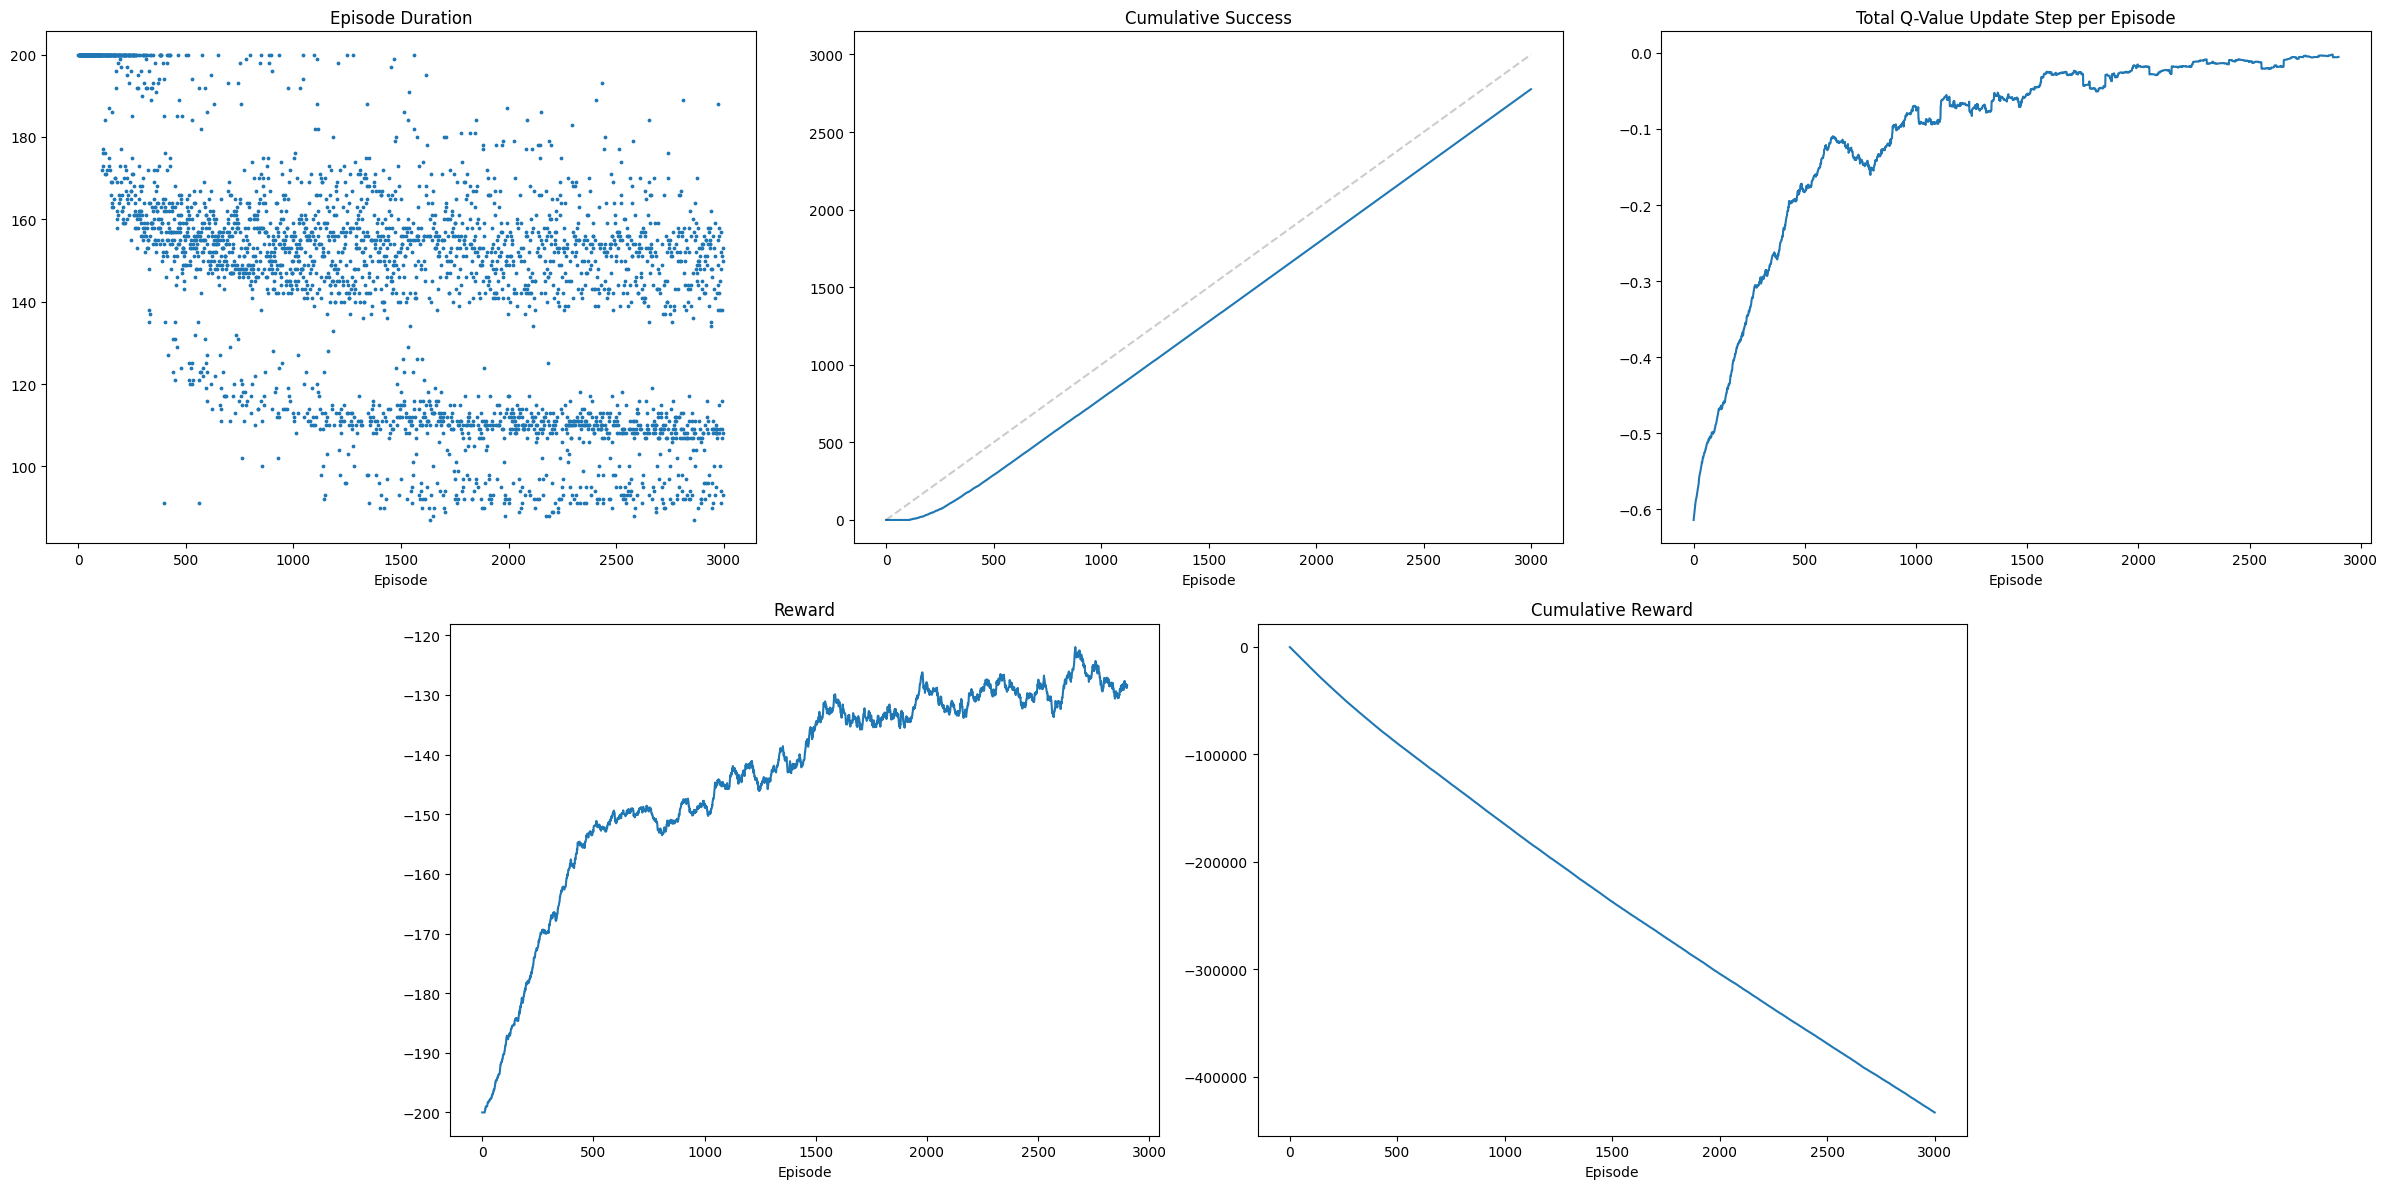

In [ ]:
fig = plt.figure(figsize=(24, 12))
gs = gridspec.GridSpec(2, 6)

wdw = 100
def moving_average(arr, window_size):
    return np.convolve(arr, np.ones(window_size), 'valid') / window_size

# First plot: Episode Duration
ax1 = plt.subplot(gs[0, 0:2])
ax1.scatter(np.arange(len(list_durations)), list_durations, s = 3)
ax1.set_title('Episode Duration')

# Second plot: Cumulative Success
ax2 = plt.subplot(gs[0, 2:4])
ax2.plot(np.arange(len(list_success)), np.cumsum(list_success))
ax2.plot(np.arange(3000), np.arange(3000), ls='--', color=(0, 0, 0, 0.2))
ax2.set_title('Cumulative Success')

# Third plot: Total Q-Value Update Step per Episode
ax3 = plt.subplot(gs[0, 4:6])
data = moving_average(list_q_values, wdw)
ax3.plot(np.arange(len(data)), data)
ax3.set_title('Total Q-Value Update Step per Episode')

# Fourth plot: Reward
ax4 = plt.subplot(gs[1, 1:3])
data = moving_average(list_total_rewards, wdw)
ax4.plot(np.arange(len(data)), data)
ax4.set_title('Reward')

# Fifth plot: Cumulative Reward
ax5 = plt.subplot(gs[1, 3:5])
ax5.plot(np.arange(len(list_total_rewards)), np.cumsum(list_total_rewards))
ax5.set_title('Cumulative Reward')

ax1.set_xlabel('Episode')
ax2.set_xlabel('Episode')
ax3.set_xlabel('Episode')
ax4.set_xlabel('Episode')
ax5.set_xlabel('Episode')
plt.tight_layout()
plt.savefig("Dyna-Results.png", bbox_inches="tight", dpi=300)
plt.show()


In [ ]:
list_total_rewards, list_durations, list_success, list_q_values, list_q_values_sum = [], [], [], [], []
for episode in tqdm.tqdm(range(3000)):
    if episode == 2999:
        kwargs = dict(render=True, video_path="video_dyna.mp4")
    else:
        kwargs = dict(render=False)

    episode_reward, duration, success, episode_q_value = run_episode_Dyna(agent=agent, environment=environment,
                                                                          heuristic_reward_function=lambda r, s, t: r, **kwargs, truncated_cap=200)
    agent.update_epsilon()
    list_total_rewards.append(episode_reward)
    list_durations.append(duration)
    list_success.append(success)
    list_q_values.append(np.mean(episode_q_value))
    list_q_values_sum.append(np.sum(episode_q_value))

100%|██████████| 3000/3000 [02:14<00:00, 22.35it/s]


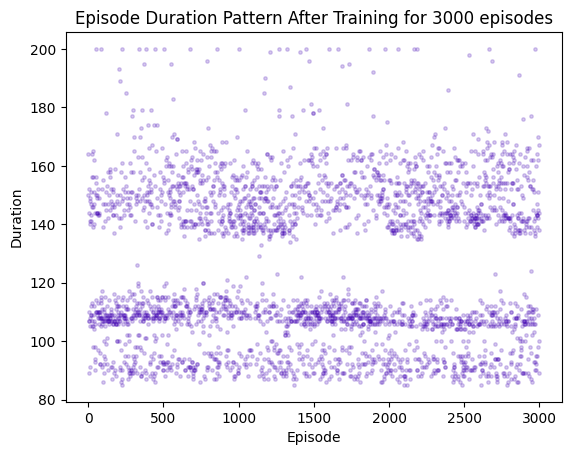

In [ ]:
plt.scatter(np.arange(len(list_durations)), list_durations, s=6, color=(0.25, 0, 0.7, 0.2))
plt.title('Episode Duration Pattern After Training for 3000 episodes')
plt.ylabel('Duration')
plt.xlabel('Episode')
plt.savefig("DYNA-duration_pattern.png", bbox_inches="tight", dpi=300)
plt.show()

In [ ]:
#make q value heat map


position_space = np.linspace(environment.observation_space.low[0], environment.observation_space.high[0], num=73)
speed_space = np.linspace(environment.observation_space.low[1], environment.observation_space.high[1], num=29)

discr_step=(0.025, 0.005)

dstate_bins = [np.arange(environment.observation_space.low[0], environment.observation_space.high[0], discr_step[0]),
                np.arange(environment.observation_space.low[1], environment.observation_space.high[1], discr_step[1])]
n_bins = [len(dstate_bins[0]), len(dstate_bins[1])]

Q2 = agent.Q.reshape(n_bins[0], n_bins[1], 3)
max_q_space = np.zeros((len(position_space), len(speed_space)))
visited_states_mask = np.any(Q2 != 0, axis=-1)
max_q_space[~visited_states_mask] = np.nan
for pdx, p in enumerate(position_space):
    for sdx, s in enumerate(speed_space):
        s_disc = agent.discretize_state(state=[p, s])
        max_q_space[pdx,sdx] = max(agent.Q[s_disc])

In [ ]:
maxQQQ = np.where(max_q_space==0, np.nan, max_q_space)

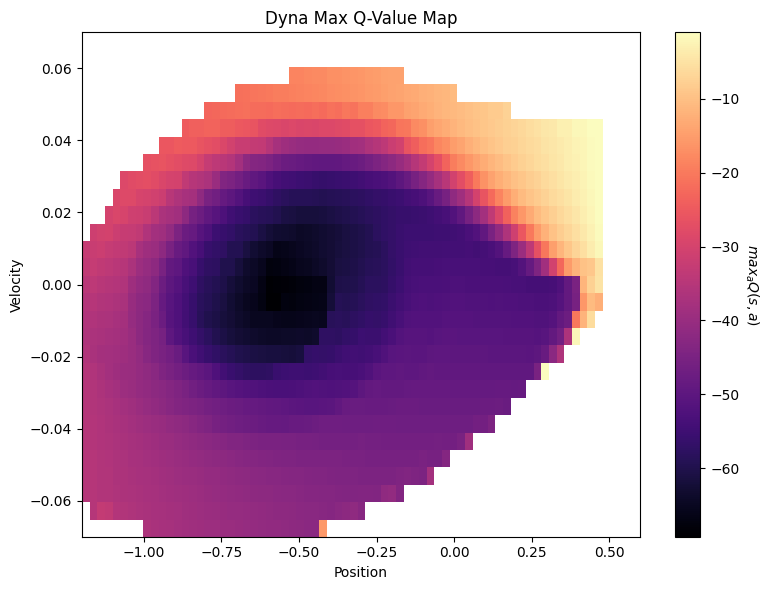

In [ ]:
plt.figure(figsize=(8, 6))
plt.title('Dyna Max Q-Value Map')
plt.imshow(maxQQQ.T,aspect='auto', origin="lower", cmap= "magma", 
           extent=[environment.observation_space.low[0], environment.observation_space.high[0], 
                                                               environment.observation_space.low[1], environment.observation_space.high[1]])
plt.xlabel('Position')
plt.ylabel('Velocity')
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.set_label('$max_a Q(s,a)$', rotation=270)
plt.tight_layout()
plt.savefig('Dyna-Q-Map.png', bbox_inches="tight", dpi=300)
plt.show()


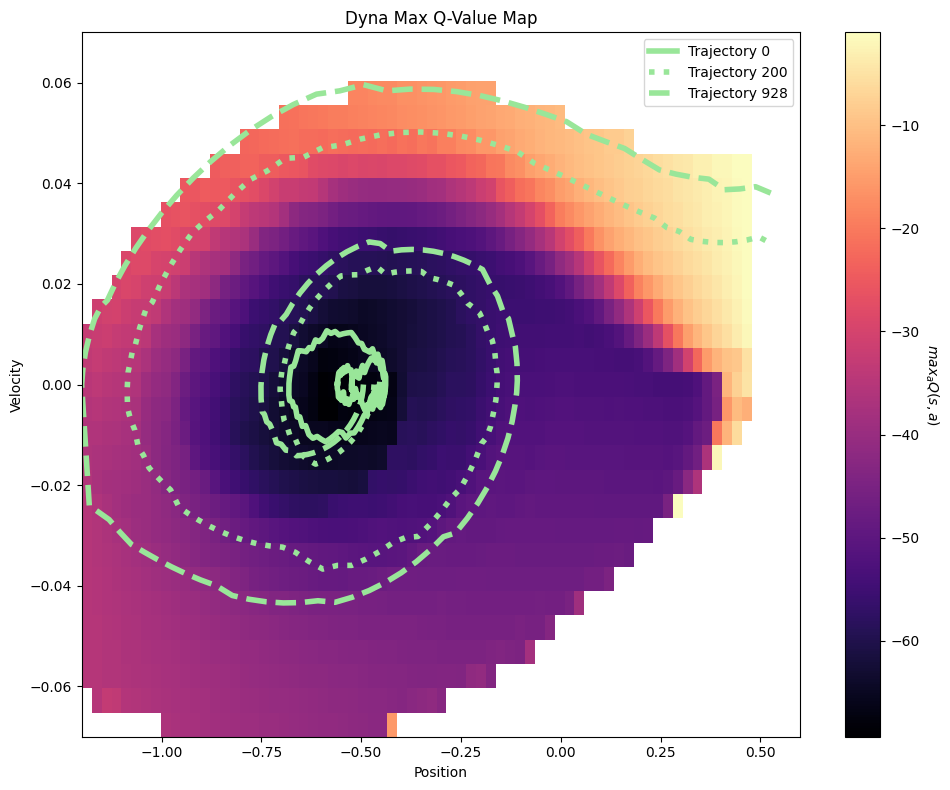

In [ ]:

position_space = np.linspace(environment.observation_space.low[0], environment.observation_space.high[0], num=72)
speed_space = np.linspace(environment.observation_space.low[1], environment.observation_space.high[1], num=280)

max_q_space = np.zeros((len(position_space), len(speed_space)))
for pdx, p in enumerate(position_space):
    for sdx, s in enumerate(speed_space):
        s_disc = agent.discretize_state(state=[p, s])
        max_q_space[pdx,sdx] = max(agent.Q[s_disc])

plt.figure(figsize=(10, 8))
plt.title('Dyna Max Q-Value Map')
plt.imshow(maxQQQ.T,aspect='auto', origin="lower", cmap= "magma", 
           extent=[environment.observation_space.low[0], environment.observation_space.high[0], 
                                                               environment.observation_space.low[1], environment.observation_space.high[1]])
plt.xlabel('Position')
plt.ylabel('Velocity')
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.set_label('$max_a Q(s,a)$', rotation=270)

#position_range = np.abs(environment.observation_space.low[0]- environment.observation_space.high[0])#/72
#velocity_range = np.abs(environment.observation_space.low[1]- environment.observation_space.high[1])#/280
ax = plt.gca()
xlim = ax.get_xlim()
ls_styles= ["-", ":", "--"]
for idx, trajectory_idx in enumerate([0, 200, 928]):
    tra = list_trajectory[trajectory_idx]
    plt.plot(tra[:, 0], tra[:, 1], color=(0.6, 0.9, 0.6),ls=ls_styles[idx], linewidth = 4, label=f"Trajectory {trajectory_idx}")

plt.legend()
plt.tight_layout()
plt.savefig('Dyna-Q-Map-Trajectories.png', bbox_inches="tight", dpi=300)
plt.show()

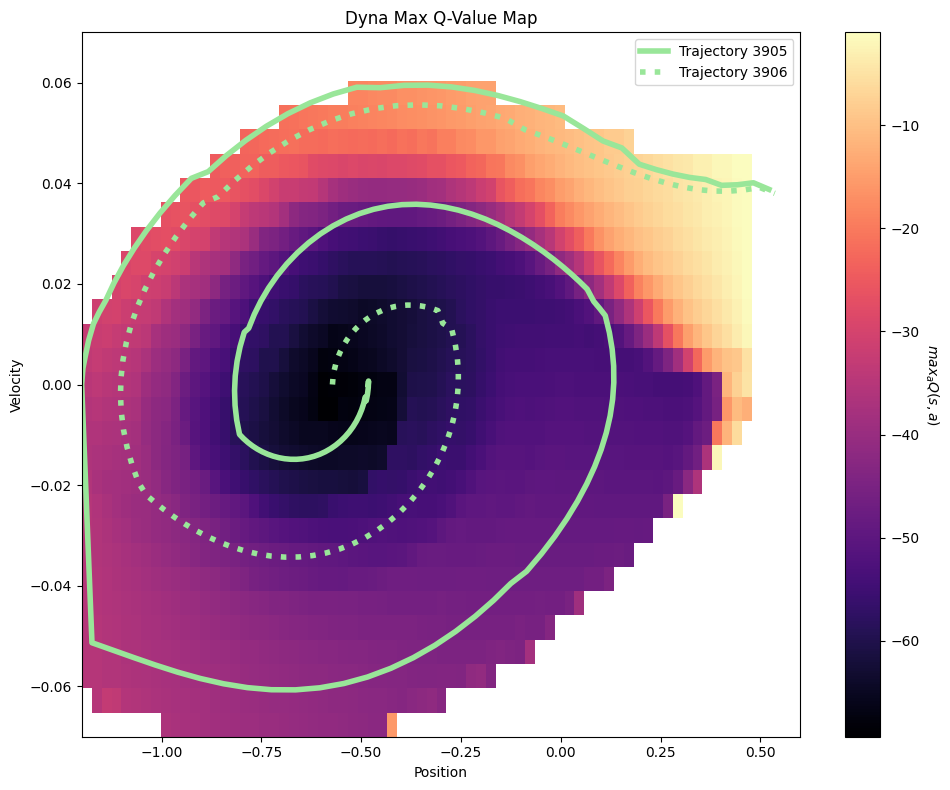

: 

In [ ]:

position_space = np.linspace(environment.observation_space.low[0], environment.observation_space.high[0], num=72)
speed_space = np.linspace(environment.observation_space.low[1], environment.observation_space.high[1], num=280)

max_q_space = np.zeros((len(position_space), len(speed_space)))
for pdx, p in enumerate(position_space):
    for sdx, s in enumerate(speed_space):
        s_disc = agent.discretize_state(state=[p, s])
        max_q_space[pdx,sdx] = max(agent.Q[s_disc])

plt.figure(figsize=(10, 8))
plt.title('Dyna Max Q-Value Map')
plt.imshow(maxQQQ.T,aspect='auto', origin="lower", cmap= "magma", 
           extent=[environment.observation_space.low[0], environment.observation_space.high[0], 
                                                               environment.observation_space.low[1], environment.observation_space.high[1]])
plt.xlabel('Position')
plt.ylabel('Velocity')
cbar = plt.colorbar()
cbar.ax.get_yaxis().labelpad = 15
cbar.set_label('$max_a Q(s,a)$', rotation=270)

#position_range = np.abs(environment.observation_space.low[0]- environment.observation_space.high[0])#/72
#velocity_range = np.abs(environment.observation_space.low[1]- environment.observation_space.high[1])#/280
ax = plt.gca()
xlim = ax.get_xlim()
ls_styles= ["-", ":", "--"]
for idx, trajectory_idx in enumerate([3905, 3906]):
    tra = list_trajectory[trajectory_idx]
    plt.plot(tra[:, 0], tra[:, 1], color=(0.6, 0.9, 0.6),ls=ls_styles[idx], linewidth = 4, label=f"Trajectory {trajectory_idx}")

plt.legend()
plt.tight_layout()
plt.savefig('Dyna-Q-Map-Trajectories-Pattern.png', bbox_inches="tight", dpi=300)
plt.show()

# 5. Compare ALL MODELS

## 5.1 Training

## a) DQN

In [87]:
environment = gym.make('MountainCar-v0', render_mode="rgb_array")

In [88]:
class Q(torch.nn.Module):
    def __init__(self):
        super(Q, self).__init__()
        self.MLP = torch.nn.Sequential(
            torch.nn.Linear(2, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 3),
        )

    def forward(self,state):
        Q_values = self.MLP(state)
        return Q_values

class DQN_Agent():
    
    def __init__(self, epsilon = 0.9, batch_size=64):
        self.Q = Q()
        self.discount_factor = 0.99
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.optimizer = torch.optim.AdamW(self.Q.parameters(), lr=1e-3)
        self.replay_buffer = ReplayBuffer()

    def observe(self, state, action, reward, next_state, done):
        self.replay_buffer.add_observation(
            torch.tensor([state[0], state[1], action, reward, next_state[0], next_state[1], done], dtype=torch.float32)
            )
    
    def update_epsilon(self):
        self.epsilon *= 0.95
        self.epsilon = max(self.epsilon, 0.05)

    def select_action(self, state):
        
        if random.random() > self.epsilon:
            with torch.no_grad():
                q_values = self.Q(torch.tensor(state, dtype=torch.float32)).numpy()
                max_q_value = np.max(q_values)
                max_actions = np.where(q_values == max_q_value)[0]
                
                return np.random.choice(max_actions)
        else:
            return environment.action_space.sample()
    
            
    def update(self):
        #batch = (B, (state_position, state_speed, action, reward, next_state_position, next_state_speed, done))

        batch = self.replay_buffer.sample_batch(self.batch_size)
        self.optimizer.zero_grad()


        current_Q_value =  torch.gather(self.Q(batch[:, :2]), dim=1, index=batch[:, 2].long().unsqueeze(1)).squeeze(1)
        batch_next_state_Q_values = self.Q(batch[:, 4:6]).clone().detach() # shape = (B, 3) 3 is action space
        batch_next_state_max_Q_value = torch.max(batch_next_state_Q_values, dim=1).values
        target_Q_value = batch[:, 3] + self.discount_factor*batch_next_state_max_Q_value*(1-batch[:, 6]) # Only reward if state is done

        loss = torch.functional.F.mse_loss(current_Q_value, target_Q_value)
        
        loss.backward()
        self.optimizer.step()
        return loss.item()
    
def identity(reward, next_state, terminated):
    return 0

def run_episode_DQN(agent, render=False, video_path="video.mp4", heuristic_reward_function=identity, truncated_cap=1e3, seed=None):

    state, _ = environment.reset()
    if (seed is not None):
        state, _ = environment.reset(seed=seed)
    done = False
    
    episode_reward = 0
    episode_environment_reward = 0
    episode_heuristic_reward = 0
    duration = 0
    success = 0
    episode_loss = []
    if render:
        frame = environment.render()
        height, width, _ = frame.shape

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(video_path, fourcc, 20.0, (width, height))

    while not done:
        if render:
            frame = environment.render()
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            out.write(frame)

        action = agent.select_action(state)
        next_state, reward, terminated, truncated, _ = environment.step(action)
        episode_environment_reward += reward
        heuristic_reward = heuristic_reward_function(state, next_state, terminated)
        episode_heuristic_reward += heuristic_reward
        reward = reward + heuristic_reward
        
        agent.observe(state, action, reward, next_state, terminated)
    
        #if (terminated):
        #    print("Goal Found:", episode_reward, duration)

        if (len(agent.replay_buffer) > agent.batch_size):
            q_network_loss = agent.update()
            episode_loss.append(q_network_loss)
            agent.update_epsilon()
        
        episode_reward += reward
        duration += 1
        if (terminated): success+=1
        state = next_state
        done = terminated or (duration > truncated_cap-1)
        
    if render:
        out.release()
    return episode_reward, episode_environment_reward, episode_heuristic_reward, duration, success, episode_loss

#run_episode_DQN()

In [59]:
def heuristic_reward_function_gpt(state, next_state, done):
    position, velocity = next_state

    position_reward = np.abs(position+0.45)

    heuristic_reward = position_reward
    if done: heuristic_reward += 10
    return heuristic_reward

In [66]:
heuristic_agent = DQN_Agent()
heur_list_env_rewards = []

for episode in tqdm.tqdm(range(3000)):
    if (episode==2999): kwargs = dict(render=True, video_path=f"video_dqn_heuristic_gpt_{episode}.mp4")
    else: kwargs = dict(render=False)

    total_reward, env_reward, heur_reward, duration, success, episode_loss = run_episode_DQN(agent=heuristic_agent, heuristic_reward_function=heuristic_reward_function_gpt,
                                                                                              **kwargs, truncated_cap=200)
    heuristic_agent.update_epsilon()
    heur_list_env_rewards.append(env_reward)

100%|██████████| 3000/3000 [03:16<00:00, 15.27it/s]


## b) RND DQN

In [73]:
rnd_agent = DQN_Agent_RND()
rnd_list_env_rewards = []

for episode in tqdm.tqdm(range(3000)):
    if (episode==2999): kwargs = dict(render=True, video_path=f"video_dqn_rnd_{episode}.mp4")
    else: kwargs = dict(render=False)

    total_reward, env_reward, heur_reward, duration, success, episode_loss = run_episode_RND(agent=rnd_agent , **kwargs, truncated_cap=200, reward_factor=0.2)
    rnd_agent.update_epsilon()
    rnd_list_env_rewards.append(env_reward)

  0%|          | 0/3000 [00:00<?, ?it/s]/var/folders/m2/wlyv38w50tz66_hy85p5msy40000gn/T/ipykernel_34206/1716440609.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(next_state, dtype=torch.float32)
100%|██████████| 3000/3000 [05:57<00:00,  8.39it/s]


# c) Dyna

In [96]:
dyna_agent = DynaAgent(environment)

dyna_list_env_rewards, list_durations, list_success, list_q_values, list_q_values_sum, list_trajectory = [], [], [], [], [], []
for episode in tqdm.tqdm(range(3000)):
    if episode == 2999:
        kwargs = dict(render=True, video_path="video_dyna.mp4")
    else:
        kwargs = dict(render=False)

    episode_reward, duration, success, episode_q_value, trajectory = run_episode_Dyna(agent=dyna_agent, environment=environment,
                                                                          heuristic_reward_function=lambda r, s, t: r, **kwargs, truncated_cap=200)
    dyna_agent.update_epsilon()

    dyna_list_env_rewards.append(episode_reward)

100%|██████████| 3000/3000 [02:33<00:00, 19.57it/s]


## training plot

In [107]:
import pandas as pd

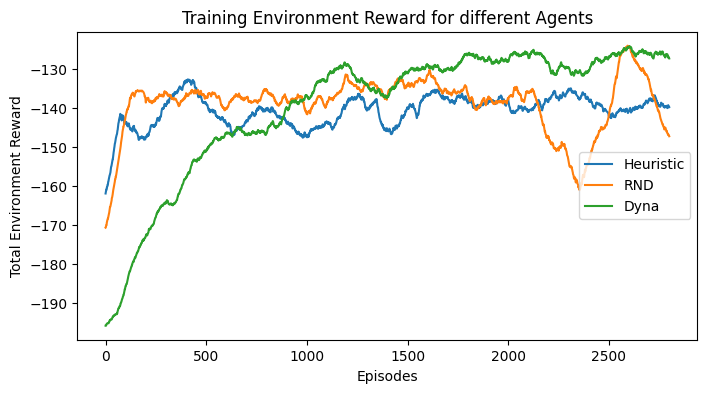

In [110]:
plt.figure(figsize = (8, 4))

window = 200
def moving_average(arr, window_size):
    return np.convolve(arr, np.ones(window_size), 'valid') / window_size

smooth = moving_average(heur_list_env_rewards, window)
plt.plot(np.arange(len(smooth)), smooth, label="Heuristic")#à, s=3)
smooth = moving_average(rnd_list_env_rewards, window)
plt.plot(np.arange(len(smooth)), smooth, label="RND")#à, s=3)
smooth = moving_average(dyna_list_env_rewards, window)
plt.plot(np.arange(len(smooth)), smooth, label='Dyna')
plt.legend(loc ='center right')
plt.title('Training Environment Reward for different Agents')
plt.xlabel('Episodes')
plt.ylabel('Total Environment Reward')
plt.savefig("5.1.png", bbox_inches ="tight", dpi=300)
plt.show()

## Testing performance

In [97]:
seeds = np.arange(1000)

In [102]:
test_heur_list_env_rewards = []
test_rnd_list_env_rewards = []
test_dyna_list_env_rewards = []

for episode in tqdm.tqdm(seeds):
    kwargs = dict(render=False)

    heuristic_agent.epsilon = 0
    rnd_agent.epsilon = 0
    dyna_agent.eps = 0

    total_reward, env_reward, heur_reward, duration, success, episode_loss = run_episode_DQN(agent=heuristic_agent, heuristic_reward_function=heuristic_reward_function_gpt,
                                                                                              **kwargs, truncated_cap=200, seed=int(episode))
    test_heur_list_env_rewards.append(env_reward)

    total_reward, env_reward, heur_reward, duration, success, episode_loss = run_episode_RND(agent=rnd_agent , **kwargs, truncated_cap=200, reward_factor=0.2, seed=int(episode))
    test_rnd_list_env_rewards.append(env_reward)

    episode_reward, duration, success, episode_q_value, trajectory = run_episode_Dyna(agent=dyna_agent, environment=environment,
                                                                          heuristic_reward_function=lambda r, s, t: r, **kwargs, truncated_cap=200, seed=int(episode))

    test_dyna_list_env_rewards.append(episode_reward)

  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/m2/wlyv38w50tz66_hy85p5msy40000gn/T/ipykernel_34206/1716440609.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(next_state, dtype=torch.float32)
100%|██████████| 1000/1000 [04:17<00:00,  3.89it/s]


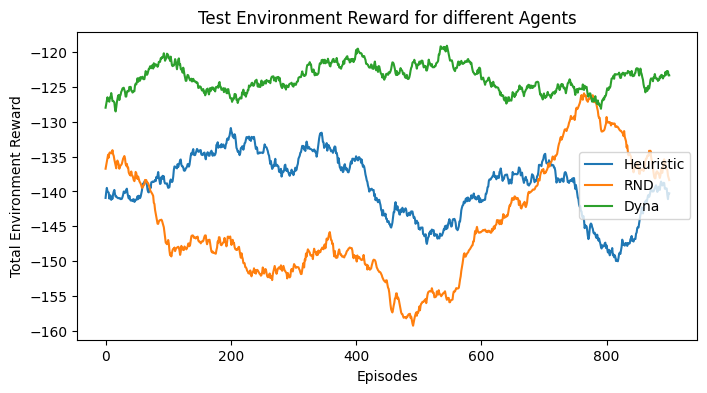

In [111]:
plt.figure(figsize = (8, 4))

window = 100
def moving_average(arr, window_size):
    return np.convolve(arr, np.ones(window_size), 'valid') / window_size

smooth = moving_average(test_heur_list_env_rewards, window)
plt.plot(np.arange(len(smooth)), smooth, label="Heuristic")#à, s=3)
smooth = moving_average(test_rnd_list_env_rewards, window)
plt.plot(np.arange(len(smooth)), smooth, label="RND")#à, s=3)
smooth = moving_average(test_dyna_list_env_rewards, window)
plt.plot(np.arange(len(smooth)), smooth, label='Dyna')
plt.legend(loc ='center right')
plt.title('Test Environment Reward for different Agents')
plt.xlabel('Episodes')
plt.ylabel('Total Environment Reward')
plt.savefig("5.2.png", bbox_inches ="tight", dpi=300)
plt.show()